In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('../input/dry-beans-classification-iti-ai-pro-intake01/train.csv')
df_train.head(3)

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
0,0,58238,971.303,397.202654,186.945510,2.124697,0.882317,58977,272.306674,0.604756,0.987470,0.775723,0.685561,0.006820,0.000929,0.469994,0.998595,HOROZ
1,1,44515,757.601,265.590470,213.967453,1.241266,0.592420,44780,238.071960,0.771745,0.994082,0.974620,0.896387,0.005966,0.002376,0.803510,0.997370,SEKER
2,2,31662,653.783,239.902428,168.421505,1.424417,0.712136,32034,200.781748,0.801407,0.988387,0.930853,0.836931,0.007577,0.002293,0.700453,0.997737,DERMASON


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10834 non-null  int64  
 1   Area             10834 non-null  int64  
 2   Perimeter        10834 non-null  float64
 3   MajorAxisLength  10834 non-null  float64
 4   MinorAxisLength  10834 non-null  float64
 5   AspectRation     10834 non-null  float64
 6   Eccentricity     10834 non-null  float64
 7   ConvexArea       10834 non-null  int64  
 8   EquivDiameter    10834 non-null  float64
 9   Extent           10834 non-null  float64
 10  Solidity         10834 non-null  float64
 11  roundness        10834 non-null  float64
 12  Compactness      10834 non-null  float64
 13  ShapeFactor1     10834 non-null  float64
 14  ShapeFactor2     10834 non-null  float64
 15  ShapeFactor3     10834 non-null  float64
 16  ShapeFactor4     10834 non-null  float64
 17  y           

**Note:**
* There are no nulls in any featrue of data.
* Features are quantitative.

# **Exploratory Data Analysis**

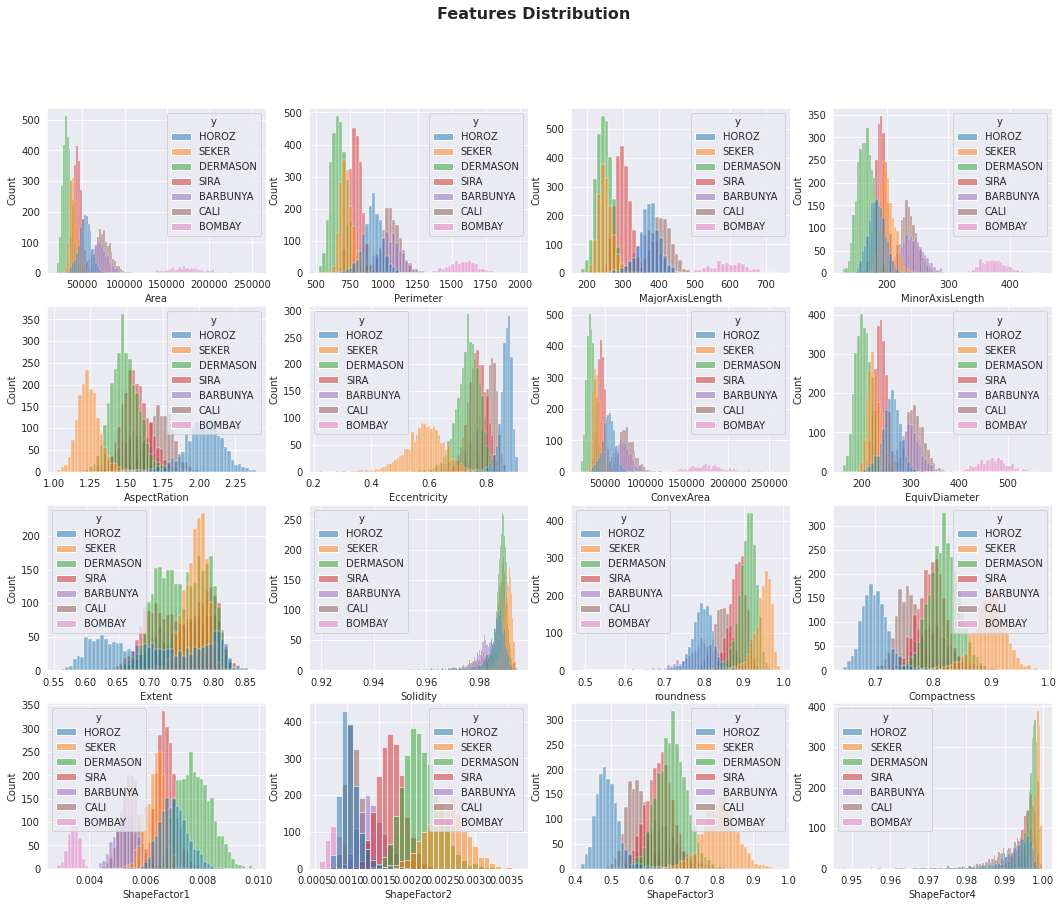

In [4]:
fig, axes = plt.subplots(nrows=4,ncols=4,figsize=(18,14))
fig.suptitle('Features Distribution',fontsize=16,fontweight='bold')
for i, ax in enumerate(axes.flat):
    sns.histplot(x=df_train.iloc[:,i+1],hue=df_train['y'],ax=ax)

## **Target**

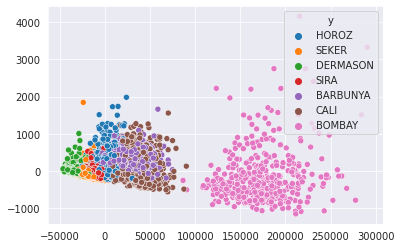

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=24)
cords = pca.fit_transform(df_train.drop(['ID','y'],axis=1))
sns.scatterplot(x=cords[:,0],y=cords[:,1],hue=df_train['y']);

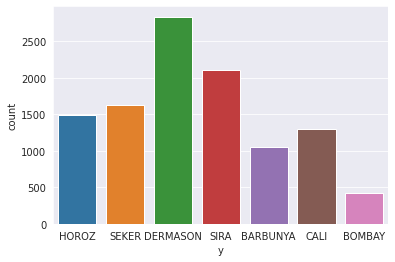

In [6]:
sns.countplot(x='y',data=df_train);

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['y'] = le.fit_transform(df_train['y'])

* The target suffuers from data imbalance.

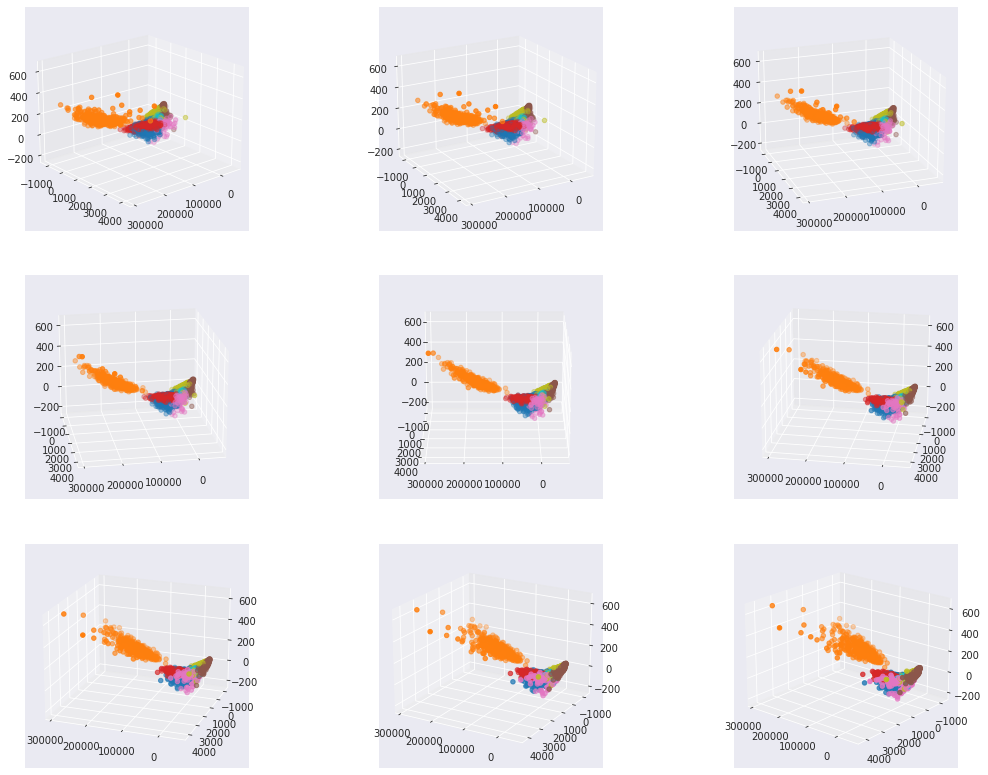

In [8]:
pca = PCA(n_components=3, random_state=24)
cords = pca.fit_transform(df_train.drop(['ID','y'],axis=1))
fig = plt.figure(figsize=(18,14))    
for i in range(1,10):
    axis = fig.add_subplot(3,3,i,projection='3d')
    axis.scatter3D(cords[:,0],cords[:,1],cords[:,2],c=df_train['y'],cmap='tab10')
    axis.view_init(20,(i*10)+40);

In [9]:
def add_ploy_feature(df,features,degree):
    """ df: dataframe.
        degree: ploynomial degree of features.
        features: features to extract ploynomial features from.
    """
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False, order='C')
    features_collection_1 = poly.fit_transform(df[features])[:,len(features):]
    return pd.concat([df,pd.DataFrame(features_collection_1)],axis=1)

In [10]:
df_train = add_ploy_feature(df_train,['ConvexArea', 'Compactness'],2)

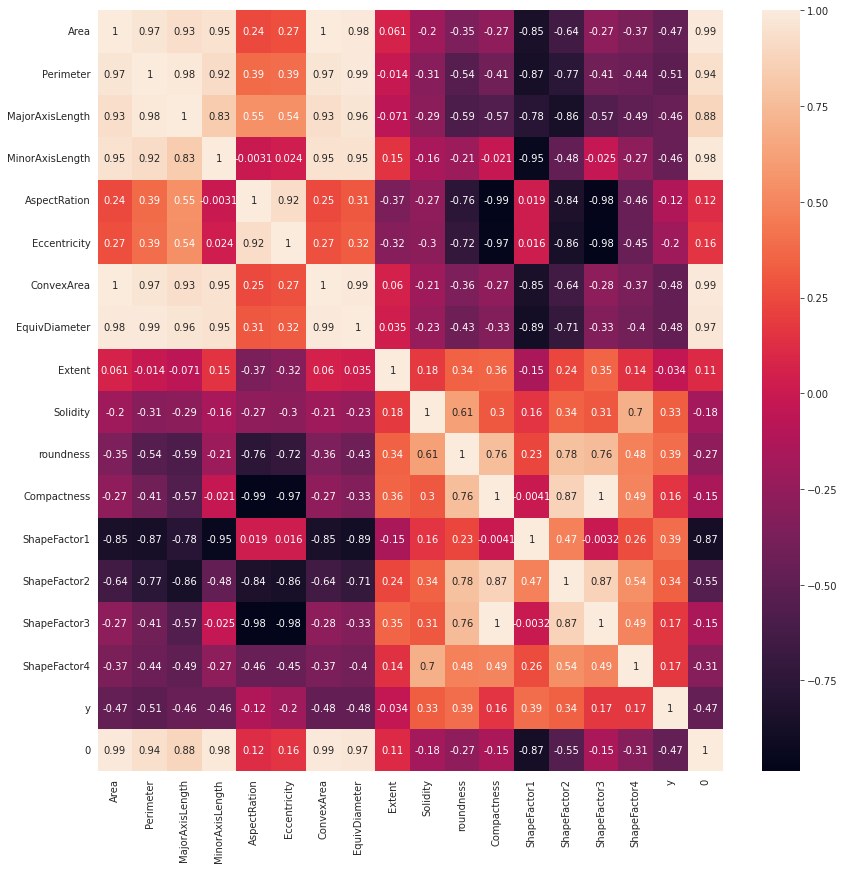

In [11]:
fig = plt.figure(figsize=(14,14))
sns.heatmap(df_train.drop(['ID'],axis=1).corr(),annot=True);

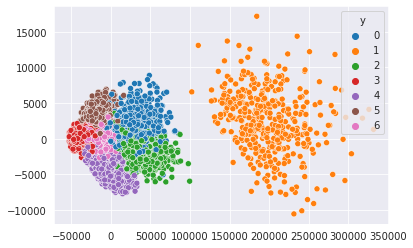

In [12]:
pca = PCA(n_components=2, random_state=24)
cords = pca.fit_transform(df_train.drop(['ID','y'],axis=1))
sns.scatterplot(x=cords[:,0],y=cords[:,1],hue=df_train['y'],palette='tab10');

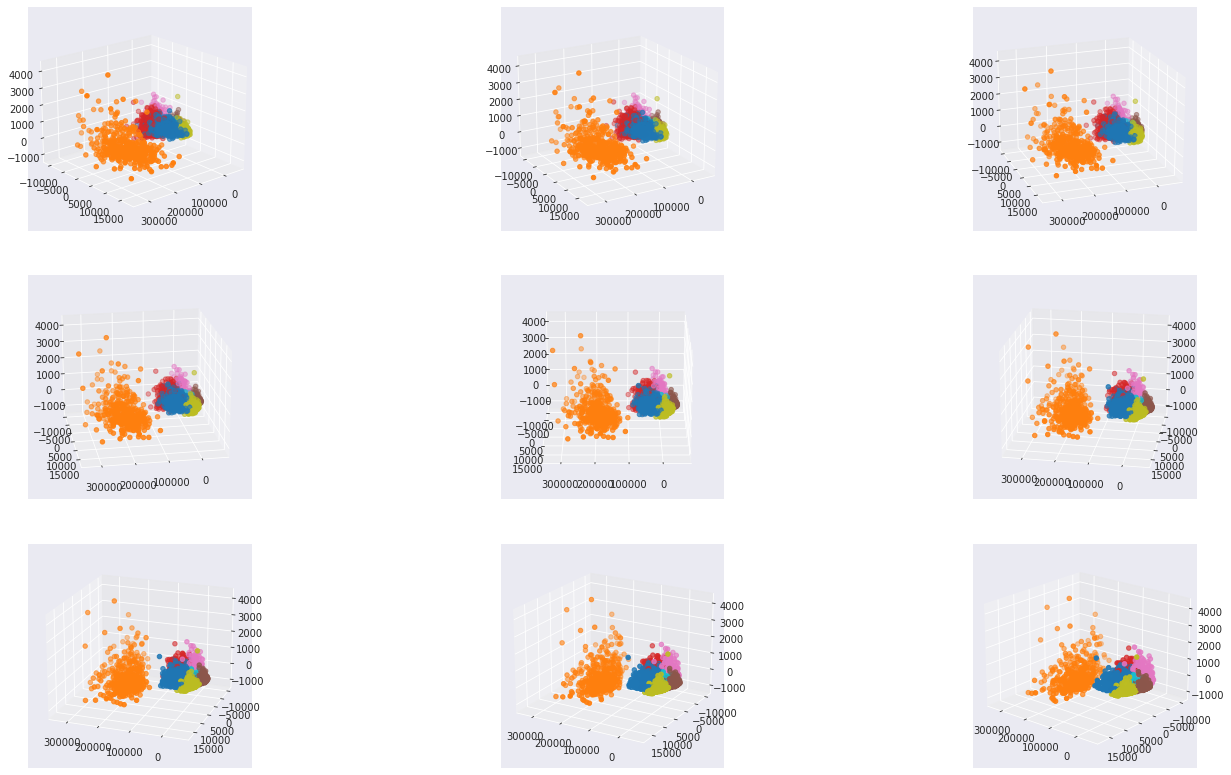

In [13]:
pca = PCA(n_components=3, random_state=24)
cords = pca.fit_transform(df_train.drop(['ID','y'],axis=1))
fig = plt.figure(figsize=(24,14))    
for i in range(1,10):
    axis = fig.add_subplot(3,3,i,projection='3d')
    axis.scatter3D(cords[:,0],cords[:,1],cords[:,2],c=df_train['y'],cmap='tab10')
    axis.view_init(20,(i*10)+40);

In [14]:
from sklearn.preprocessing import MinMaxScaler,PowerTransformer,StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_train.drop(['ID','y'],axis=1))

In [15]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', df_train['y'].unique(), df_train['y'])

class_weights = dict()
for i,j in zip(df_train['y'].unique(),weights):
    class_weights[i] = j

### **Support Vector Classifier**

In [16]:
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,plot_roc_curve,f1_score

X_train,X_test,y_train,y_test = train_test_split(scaled_data, df_train['y'],test_size=0.2,random_state=24)

mlp = MLPClassifier(
    max_iter = 2000,
    learning_rate = 'adaptive',
    alpha = 0.005,
    random_state=24
)
svc = SVC(
    class_weight = 'balanced',
    probability = True,
    C = 10,
    random_state=24
#     gamma = 0.01
)
cbc = CatBoostClassifier(
    logging_level = 'Silent',
    random_seed = 24,
    iterations = 1000,
    max_depth = 3,
    learning_rate = 0.2,
    model_shrink_rate = 0.8,
    grow_policy="Depthwise",
    model_shrink_mode = "Decreasing",
    auto_class_weights='SqrtBalanced',
)

model = VotingClassifier(estimators=[('cbc', cbc), ('svc', svc), ('mlp', mlp)], voting='soft')

model.fit(X_train, y_train)

print(classification_report(y_test,model.predict(X_test)))
print('train score : ', f1_score(y_train, model.predict(X_train), average='macro'))
print('test score : ', f1_score(y_test, model.predict(X_test), average='macro'))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       212
           1       1.00      1.00      1.00        91
           2       0.95      0.96      0.96       260
           3       0.94      0.91      0.93       574
           4       0.97      0.97      0.97       285
           5       0.96      0.96      0.96       313
           6       0.89      0.92      0.90       432

    accuracy                           0.94      2167
   macro avg       0.95      0.95      0.95      2167
weighted avg       0.94      0.94      0.94      2167

train score :  0.957160611530688
test score :  0.9517461407748146


**BARBUNYA**:0,   **BOMBAY**:1,   **CALI**:2,   **DERMASON**:3,   **HOROZ**:4,   **SEKER**:5,   **SIRA**:6

In [17]:
X = scaled_data
Y = df_train['y']
model.fit(X,Y)
print('train score : ', f1_score(Y, model.predict(X), average='macro'))

train score :  0.9563397418919999


## **Test Data**

In [18]:
df_test = pd.read_csv('../input/dry-beans-classification-iti-ai-pro-intake01/test.csv')
df_test.head(2)

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,10834,57659,955.434,387.757607,196.625782,1.972059,0.861896,60188,270.949661,0.620790,0.957982,0.793735,0.698760,0.006725,0.000989,0.488266,0.962889
1,10835,28772,630.362,229.990785,159.609367,1.440960,0.719993,29127,191.399185,0.767458,0.987812,0.909913,0.832204,0.007994,0.002365,0.692563,0.997956


In [19]:
df_test = add_ploy_feature(df_test,['ConvexArea', 'Compactness'],2)
X_test = scaler.fit_transform(df_test.drop(['ID'],axis=1))
y_pred = model.predict(X_test)
out_prediction = pd.DataFrame(le.inverse_transform(y_pred))[0]

In [20]:
submission = pd.read_csv('../input/dry-beans-classification-iti-ai-pro-intake01/sample_submission.csv')
submission['y'] = out_prediction
submission.to_csv('my_submission.csv', index=False)